In [1]:
import sys
import os
# Go three levels up from current file (i.e., from notebooks/ to project/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import numpy as np
import matplotlib.pyplot as plt
import utils.mpl_pubstyle  # noqa: F401


# Plot CPU times for IMEX-RB on 2D nonlinear problem
We study CPU times on the 2D viscous Burgers equation

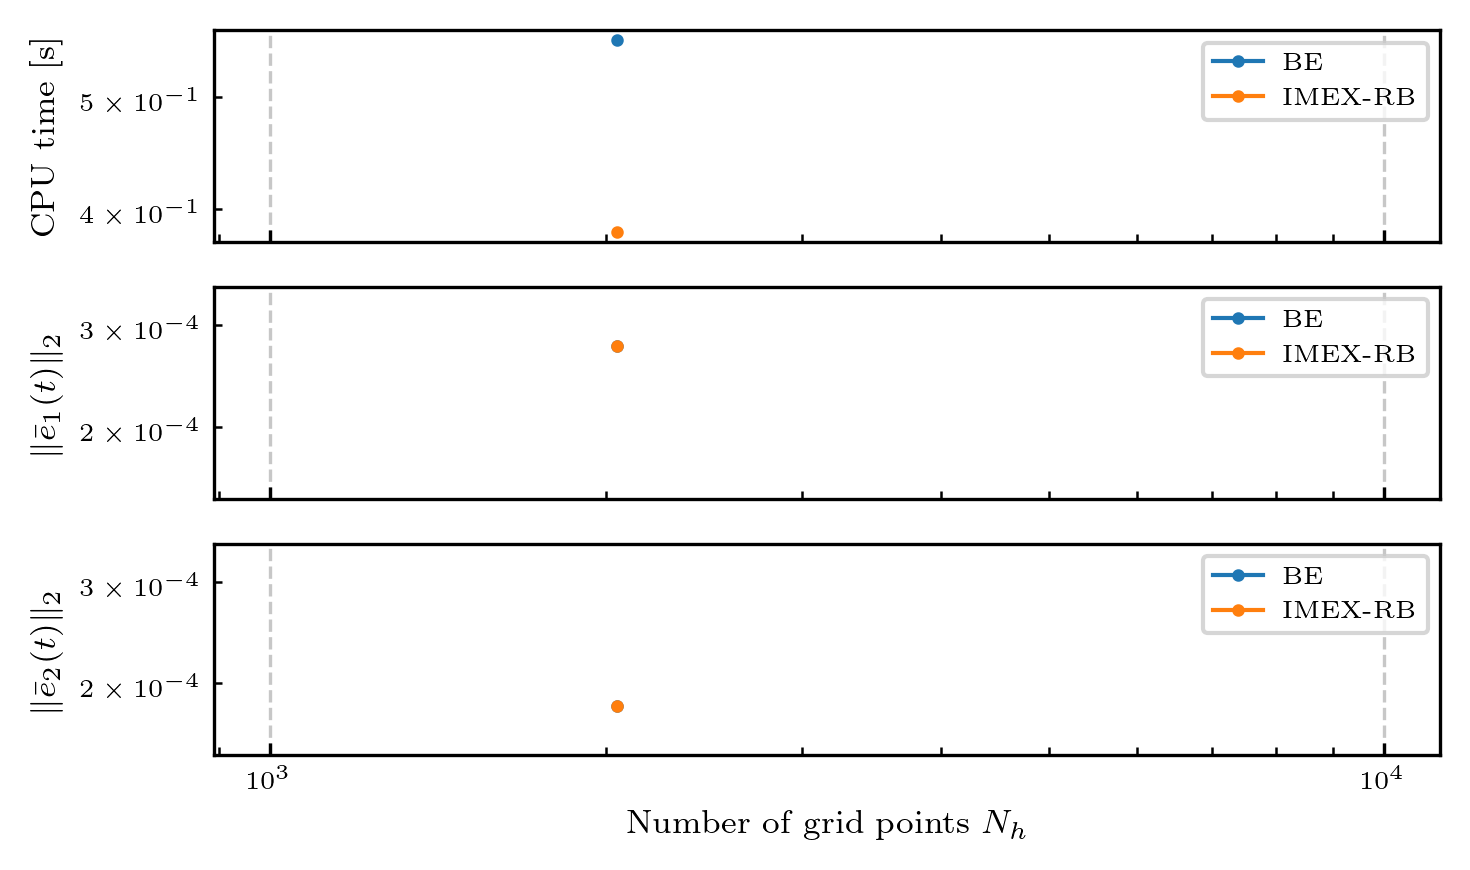

In [2]:
# Retrieve data
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))
results_path = os.path.join(
    base_dir, os.pardir, os.pardir, 'results',
    'Burgers2D', 'CPUtimes', 'Test1', 'results.npz'
)
plots_dir = os.path.join(base_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

data = np.load(results_path, allow_pickle=True)
times = data['times'].item()
errors_l2 = data['errors_l2'].item()
Nh_values = data['Nh_values']

methods = ['BE', 'IMEX-RB']
comp_labels = ['u_x', 'u_y']

fig, axes = plt.subplots(3, 1, figsize=(5, 3), sharex=True)

# CPU times
for m in methods:
    axes[0].loglog(Nh_values, times[m], marker='o', label=m)
axes[0].set_ylabel('CPU time [s]')
axes[0].legend()
# axes[0].set_title('CPU time vs $N_h$')

# l2 errors for each component
for i in range(2):
    ax = axes[i + 1]
    for m in methods:
        ax.loglog(Nh_values, errors_l2[m][i], marker='o', label=m)
    ax.set_ylabel(fr'$\|\bar{{e}}_{i+1}(t)\|_{2}$')
    ax.set_ylim((1.5e-4, 3.5e-4))
    ax.legend()

axes[-1].set_xlabel('Number of grid points $N_h$')
plt.tight_layout()
out_file = os.path.join(
    plots_dir, 'Burgers2D_cputimes_errors.pdf'
)
plt.savefig(out_file)
plt.show()
plt.close()